In [1]:
!pip install neo4j
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric

     |████████████████████████████████| 81kB 6.1MB/s 
  Created wheel for neo4j: filename=neo4j-4.3.1-cp37-none-any.whl size=99332 sha256=ad0b67bc9f7b73d3b46ebeeacb1060d487ac05d675cd5a7e4a576ddbcbd51268
  Stored in directory: /root/.cache/pip/wheels/23/13/72/0cc2405898bd9a7baef6512df3abf83873da9ba48c04acc818
Successfully built neo4j
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6MB 8.0MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4MB 6.4MB/s 
     |████████████████████████████████| 225kB 6.7MB/s 
     |████████████████████████████████| 235kB 11.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-cp37-none-any.whl size=388143 sha256=5f1e256d4e8ae3353f01f4c9f6766c137a681beffcf4fd3fc2196a1864d6bea4
  Stored in directory: /root/.cache/pip/wheels/e7/66/5b/ad17ef7f04b7c4

In [2]:
import os
import pickle
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# set seed
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
DATA_PATH = "/home"

assert os.path.isdir(DATA_PATH)

In [5]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root=DATA_PATH, name='MUTAG')

Extracting /home/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
from neo4j import GraphDatabase, basic_auth

driver = GraphDatabase.driver(
  "bolt://3.239.37.24:7687",
  auth=basic_auth("neo4j", "cockpits-interviewers-directives"))

In [7]:
cypher_query = '''
UNWIND $items AS item
MERGE (a:Atom {element: item.atom_0_elmt, atom_id: item.atom_0, molecule_id: item.mol_id, mutagenic: item.mutagen})
MERGE (b:Atom {element: item.atom_1_elmt, atom_id: item.atom_1, molecule_id: item.mol_id, mutagenic: item.mutagen})
MERGE (a)-[:BONDED_TO {bond_type: item.bond}]-(b)
'''

edges = []
elements = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
bonds = ['AROMATIC', 'SINGLE', 'DOUBLE', 'TRIPLE']

def create_graph(tx, edges):
  tx.run(cypher_query, items=edges)

with driver.session() as session:
  for mol_id in range(len(dataset)):
    for bond_id in range(dataset[mol_id]['edge_index'].size()[1]):
      atom_0 = int(dataset[mol_id]['edge_index'][:, bond_id][0])
      atom_1 = int(dataset[mol_id]['edge_index'][:, bond_id][1])
      atom_0_elmt = elements[int(torch.argmax(dataset[mol_id]['x'][atom_0]))]
      atom_1_elmt = elements[int(torch.argmax(dataset[mol_id]['x'][atom_1]))]
      bond = bonds[int(torch.argmax(dataset[mol_id]['edge_attr'][bond_id]))]
      edges.append(
          {'mol_id': mol_id,
          'mutagen': int(dataset[mol_id]['y']),
          'atom_0': atom_0,
          'atom_1': atom_1,
          'atom_0_elmt': atom_0_elmt,
          'atom_1_elmt': atom_1_elmt,
          'bond': bond}
          )
      if len(edges) % 1000 == 0:
          session.write_transaction(create_graph, edges)
          edges = []
  session.write_transaction(create_graph, edges)

driver.close()

In [8]:
cypher_query = '''
MATCH (a:Atom)
RETURN a.molecule_id AS molecule,
a.atom_id AS atom_id,
a.mutagenic AS y,
a.element AS element
'''

with driver.session(database="neo4j") as session:
  results_0 = session.read_transaction(
    lambda tx: tx.run(cypher_query).data())

driver.close()

In [9]:
cypher_query = '''
MATCH (a:Atom)-[b:BONDED_TO]-(c:Atom)
RETURN a.molecule_id AS molecule,
b.bond_type AS bond,
a.atom_id AS atom_0,
c.atom_id AS atom_1
'''

with driver.session(database="neo4j") as session:
  results_1 = session.read_transaction(
    lambda tx: tx.run(cypher_query).data())

driver.close()

In [10]:
import pandas as pd
from torch_geometric.data import Data

bonds_df = pd.DataFrame(results_1)
bonds_df = pd.get_dummies(bonds_df, columns=['bond'])

atoms_df = pd.DataFrame(results_0)
atoms_df = pd.get_dummies(atoms_df, columns=['element'])

reconstructed_MUTAG = []
for mol_id in bonds_df['molecule'].unique():
  y = torch.tensor(atoms_df.loc[atoms_df['molecule'] == mol_id]['y'].unique(), dtype=torch.int64)
  x = torch.tensor(atoms_df.loc[atoms_df['molecule'] == mol_id].iloc[:,-7:].to_numpy(), dtype=torch.float32)
  edge_attr = torch.tensor(bonds_df.loc[bonds_df['molecule'] == mol_id].iloc[:,-4:].to_numpy(), dtype=torch.float32)
  edge_index = torch.tensor(bonds_df.loc[bonds_df['molecule'] == mol_id][['atom_0', 'atom_1']].to_numpy().T, dtype=torch.int64)
  reconstructed_MUTAG.append(Data(edge_attr=edge_attr, edge_index=edge_index, x=x, y=y))

In [11]:
def graph_stat(dataset):
    """
    Outputs:
        min_num_nodes: min number of nodes
        max_num_nodes: max number of nodes
        mean_num_nodes: average number of nodes
        min_num_edges: min number of edges
        max_num_edges: max number of edges
        mean_num_edges: average number of edges
    """
    num_nodes = [data.num_nodes for data in dataset]
    num_edges = [data.num_edges for data in dataset]
    min_num_nodes = np.min(num_nodes)
    max_num_nodes = np.max(num_nodes)
    mean_num_nodes = np.mean(num_nodes)
    min_num_edges = np.min(num_edges)
    max_num_edges = np.max(num_edges)
    mean_num_edges = np.mean(num_edges)
    print("min_num_nodes: {}".format(min_num_nodes))
    print("max_num_nodes: {}".format(max_num_nodes))
    print("mean_num_nodes: {}".format(mean_num_nodes))
    print("min_num_edges: {}".format(min_num_edges))
    print("max_num_edges: {}".format(max_num_edges))
    print("mean_num_edges: {}".format(mean_num_edges))

In [12]:
graph_stat(dataset)

min_num_nodes: 10
max_num_nodes: 28
mean_num_nodes: 17.930851063829788
min_num_edges: 20
max_num_edges: 66
mean_num_edges: 39.58510638297872


In [13]:
graph_stat(reconstructed_MUTAG)

min_num_nodes: 10
max_num_nodes: 28
mean_num_nodes: 17.930851063829788
min_num_edges: 20
max_num_edges: 66
mean_num_edges: 39.58510638297872


In [14]:
from torch_geometric.data import DataLoader

dataset = dataset.shuffle()

split_idx = int(len(dataset) * 0.8)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv_1 = GCNConv(7, 64)
        self.activ_1 = nn.ReLU()
        self.conv_2 = GCNConv(64, 64)
        self.activ_2 = nn.ReLU()
        self.conv_3 = GCNConv(64, 64)
        self.dropout = nn.Dropout()
        self.linear = nn.Linear(64, 2)

    def forward(self, x, edge_index, batch):
        """
        Arguments:
            x: [num_nodes, 7], node features
            edge_index: [2, num_edges], edges
            batch: [num_nodes], batch assignment vector which maps each node to its 
                   respective graph in the batch

        Outputs:
            probs: probabilities of shape (batch_size, 2)
        """
        x = self.conv_1(x, edge_index)
        x = self.activ_1(x)
        x = self.conv_2(x, edge_index)
        x = self.activ_2(x)
        x = self.conv_3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.linear(x)
        return x

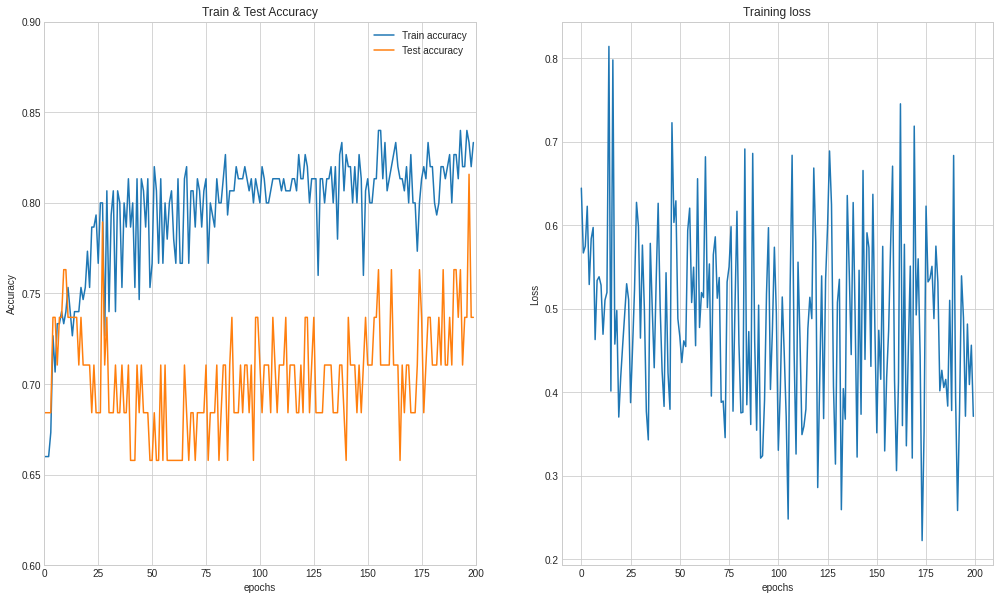

In [17]:
gcn = GCN()

optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(train_loader):
    gcn.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = gcn(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
    return loss

def test(loader):
    gcn.eval()
    correct = 0
    for data in loader:
        out = gcn(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Predict the most probable class
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)  # Return the accuracy

acc_plt = []
TestAcc_lst = []
loss_lst = []
epoch_lst = []
for epoch in range(200):
    train_loss = train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    acc_plt.append(train_acc)
    TestAcc_lst.append(test_acc)
    epoch_lst.append(epoch)
    loss_lst.append(train_loss)

# plot accuracy and loss
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

x_plt = epoch_lst 
y1_plt = acc_plt
y2_plt = TestAcc_lst
y3_plt = loss_lst

fig, ax = plt.subplots(1,2, figsize=(17,10))
ax[0].plot(x_plt, y1_plt, label='Train accuracy')
ax[0].plot(x_plt, y2_plt, label='Test accuracy')
ax[1].plot(x_plt, y3_plt, label='Loss')

ax[0].set(xlabel='epochs', ylabel='Accuracy',
        title='Train & Test Accuracy')
ax[0].legend(loc='best')
ax[0].axis([0, 200, 0.6,0.9])
ax[1].set(xlabel='epochs', ylabel='Loss', title='Training loss')
plt.show()